# DKD Workflow: Detect DKD → Risk Probability → Stage Prediction

Implements:
1. Load dataset
2. Preprocess + handle class imbalance
3. Train MLP for DKD detection and DKD stage classification
4. Evaluate (confusion matrix, accuracy/loss curves, ROC)
5. Compare with Random Forest and XGBoost
6. Explain with SHAP (global + patient-level)

Update `DATA_PATH`, label columns, and `FEATURE_COLS` to match your file.

In [11]:

# Optional installs (uncomment if needed)
!pip -q install xgboost shap imbalanced-learn

import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    accuracy_score, roc_curve, auc, RocCurveDisplay
)

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import shap

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1) Load dataset and define columns

In [21]:
import os
import pandas as pd

# -------------------------
# 1) CONFIG
# -------------------------

DATA_PATH = r"C:\Users\DELL\Desktop\DKD_peper\DKD_Research\updated_ckd_dataset_with_stages.csv"
# DATA_PATH = r"/DKD/updated_ckd_dataset_with_stages.csv"


BINARY_LABEL_COL = "ckd_pred"   # DKD present? 0/1 or Yes/No
STAGE_LABEL_COL  = "ckd_stage"  # DKD stage (1–5)

# If None, all non-label columns will be used as features
FEATURE_COLS = None

# -------------------------
# 2) FILE EXISTENCE CHECK (BUG-PROOF)
# -------------------------

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"❌ Dataset not found!\n"
        f"Expected location:\n{DATA_PATH}\n\n"
        f"➡️ Fix: Move the CSV to this path or update DATA_PATH."
    )

# -------------------------
# 3) LOAD DATA
# -------------------------

df = pd.read_csv(DATA_PATH)

# -------------------------
# 4) FEATURE SELECTION
# -------------------------

if FEATURE_COLS is None:
    FEATURE_COLS = [
        c for c in df.columns
        if c not in [BINARY_LABEL_COL, STAGE_LABEL_COL]
    ]

# -------------------------
# 5) BASIC DATA CHECKS
# -------------------------

print("✅ Dataset loaded successfully")
print("Rows:", len(df))
print("Num features:", len(FEATURE_COLS))

print("\nBinary label sample counts:")
print(df[BINARY_LABEL_COL].value_counts(dropna=False))

print("\nStage label sample counts:")
print(df[STAGE_LABEL_COL].value_counts(dropna=False))

print("\nFeature columns:")
print(FEATURE_COLS)


✅ Dataset loaded successfully
Rows: 4000
Num features: 21

Binary label sample counts:
ckd_pred
CKD       3875
No CKD     125
Name: count, dtype: int64

Stage label sample counts:
ckd_stage
2    1004
3     866
4     794
5     666
1     545
0     125
Name: count, dtype: int64

Feature columns:
['serum_creatinine', 'gfr', 'bun', 'serum_calcium', 'ana', 'c3_c4', 'hematuria', 'oxalate_levels', 'urine_ph', 'blood_pressure', 'physical_activity', 'diet', 'water_intake', 'smoking', 'alcohol', 'painkiller_usage', 'family_history', 'weight_changes', 'stress_level', 'months', 'cluster']


## 2) Preprocess + normalize labels + handle imbalance

- Numeric: median impute + standardize
- Categorical: most-frequent impute + one-hot
- Imbalance: SMOTE on TRAIN split only

In [13]:
def normalize_binary(y: pd.Series) -> pd.Series:
    # Numeric already (0/1)
    if pd.api.types.is_numeric_dtype(y):
        return y.astype(int)

    y_str = y.astype(str).str.strip().str.lower()

    mapping = {
        # Positive
        "1": 1,
        "yes": 1,
        "true": 1,
        "ckd": 1,
        "dkd": 1,
        "positive": 1,
        "pos": 1,
        "ckd positive": 1,

        # Negative
        "0": 0,
        "no": 0,
        "false": 0,
        "non-ckd": 0,
        "non ckd": 0,
        "no ckd": 0,          # 🔥 FIX
        "not ckd": 0,
        "negative": 0,
        "neg": 0,
        "normal": 0,
    }

    y_mapped = y_str.map(mapping)

    if y_mapped.isna().any():
        missing = sorted(y_str[y_mapped.isna()].unique().tolist())
        raise ValueError(
            f"Unmapped binary label values found: {missing}\n"
            f"➡️ Please update normalize_binary() mapping."
        )

    return y_mapped.astype(int)


### normalize_stage

In [14]:
def normalize_stage(y: pd.Series) -> pd.Series:
    # Keep NaN for non-DKD or missing stage; otherwise coerce to int if possible
    if pd.api.types.is_numeric_dtype(y):
        return y

    y_str = y.astype(str).str.strip()

    # Extract numbers from strings like "Stage 3", "CKD-4", etc.
    extracted = y_str.str.extract(r"(\d+)")[0]

    return pd.to_numeric(extracted, errors="coerce")


## preprocess

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Identify column types
num_cols = [c for c in FEATURE_COLS if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in FEATURE_COLS if c not in num_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)


## 3) Train/test split

One split reused across all models.

Stage data is built only from DKD-positive cases with known stage.

In [16]:
# -------------------------
# 3) Train/test split
# -------------------------
# One split reused across all models.
# Stage data is built only from DKD-positive cases with known stage.

# ---- SAFETY CHECKS (NO FUNCTIONAL CHANGE) ----
if "y_bin" not in globals():
    y_bin = normalize_binary(df[BINARY_LABEL_COL].copy())

if "y_stage" not in globals():
    y_stage = normalize_stage(df[STAGE_LABEL_COL].copy())

if "X" not in globals():
    X = df[FEATURE_COLS].copy()

# ---- TRAIN / TEST SPLIT ----
X_train, X_test, yb_train, yb_test, ys_train, ys_test = train_test_split(
    X, y_bin, y_stage,
    test_size=0.2,
    random_state=SEED,
    stratify=y_bin
)

# ---- PREPROCESS (FIT ON TRAIN ONLY) ----
Xb_train_proc = preprocess.fit_transform(X_train)
Xb_test_proc  = preprocess.transform(X_test)

# ---- BALANCE BINARY TRAINING DATA ----
smote_bin = SMOTE(random_state=SEED)
Xb_train_bal, yb_train_bal = smote_bin.fit_resample(
    Xb_train_proc, yb_train
)

print("Binary train counts (before):", np.bincount(yb_train))
print("Binary train counts (after) :", np.bincount(yb_train_bal))

# ---- STAGE DATA (ONLY DKD-POSITIVE WITH STAGE) ----
train_mask_stage = (yb_train == 1) & (ys_train.notna())
test_mask_stage  = (yb_test  == 1) & (ys_test.notna())

Xs_train = X_train.loc[train_mask_stage]
Xs_test  = X_test.loc[test_mask_stage]

ys_train_clean = ys_train.loc[train_mask_stage].astype(int)
ys_test_clean  = ys_test.loc[test_mask_stage].astype(int)

Xs_train_proc = preprocess.transform(Xs_train)
Xs_test_proc  = preprocess.transform(Xs_test)

# ---- MAP STAGES TO 0..K-1 (FOR PYTORCH) ----
stage_classes = sorted(ys_train_clean.unique().tolist())
stage_to_idx = {s: i for i, s in enumerate(stage_classes)}
idx_to_stage = {i: s for s, i in stage_to_idx.items()}

y_train_stage_idx = ys_train_clean.map(stage_to_idx).to_numpy()
y_test_stage_idx  = ys_test_clean.map(stage_to_idx).to_numpy()

# ---- BALANCE STAGE TRAINING (OPTIONAL) ----
try:
    smote_stage = SMOTE(random_state=SEED)
    Xs_train_bal, ys_train_bal = smote_stage.fit_resample(
        Xs_train_proc, y_train_stage_idx
    )
    print("Stage classes:", stage_classes)
    print("Stage train counts (after SMOTE):", np.bincount(ys_train_bal))
except Exception as e:
    print("Stage SMOTE failed; falling back to unbalanced stage training.")
    print("Reason:", e)
    Xs_train_bal, ys_train_bal = Xs_train_proc, y_train_stage_idx


Binary train counts (before): [ 100 3100]
Binary train counts (after) : [3100 3100]
Stage classes: [1, 2, 3, 4, 5]
Stage train counts (after SMOTE): [810 810 810 810 810]


## 4) MLP models (PyTorch)

Train:
- Binary DKD detector (outputs DKD probability)
- Stage classifier (only for DKD-positive patients)

Plots:
- accuracy curve
- loss curve
- ROC curve (binary)

Epoch 001 | train_loss=0.2681 train_acc=0.902 | val_loss=0.0919 val_acc=0.956
Epoch 010 | train_loss=0.0090 train_acc=0.997 | val_loss=0.0263 val_acc=0.986
Epoch 020 | train_loss=0.0020 train_acc=0.999 | val_loss=0.0322 val_acc=0.988
Epoch 030 | train_loss=0.0028 train_acc=0.999 | val_loss=0.0429 val_acc=0.986
Epoch 040 | train_loss=0.0009 train_acc=1.000 | val_loss=0.0611 val_acc=0.985
Epoch 050 | train_loss=0.0002 train_acc=1.000 | val_loss=0.0529 val_acc=0.986
Epoch 060 | train_loss=0.0006 train_acc=1.000 | val_loss=0.0585 val_acc=0.985
Epoch 070 | train_loss=0.0042 train_acc=0.999 | val_loss=0.0638 val_acc=0.986
Epoch 080 | train_loss=0.0011 train_acc=1.000 | val_loss=0.1003 val_acc=0.981
Epoch 090 | train_loss=0.0018 train_acc=1.000 | val_loss=0.0828 val_acc=0.986
Epoch 100 | train_loss=0.0003 train_acc=1.000 | val_loss=0.0928 val_acc=0.983
Epoch 110 | train_loss=0.0000 train_acc=1.000 | val_loss=0.0989 val_acc=0.985
Epoch 120 | train_loss=0.0000 train_acc=1.000 | val_loss=0.1109 

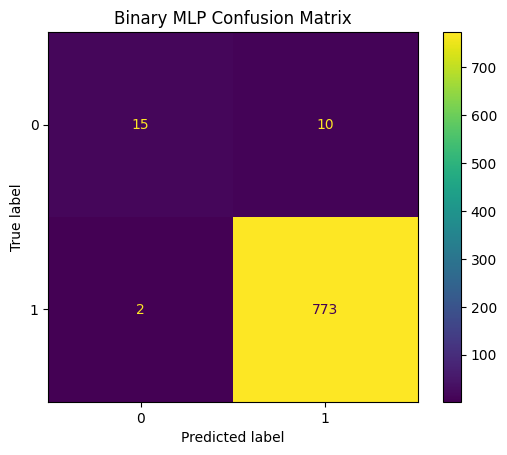

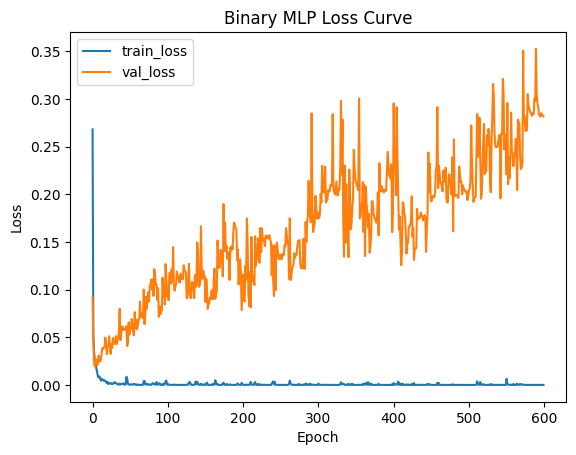

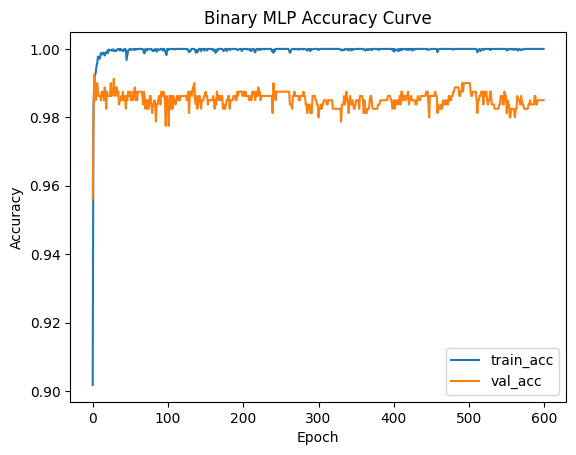

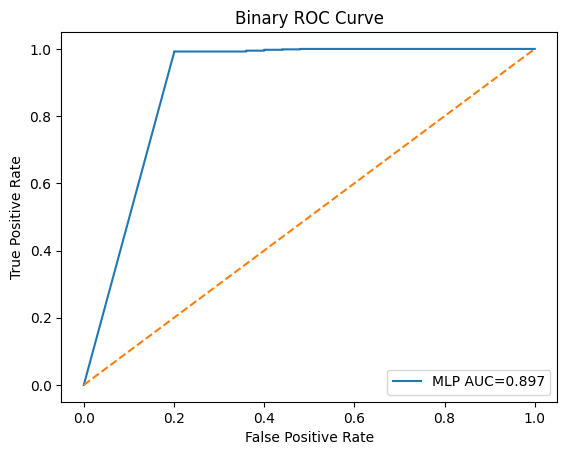

Epoch 001 | train_loss=1.3749 train_acc=0.414 | val_loss=1.0197 val_acc=0.603
Epoch 010 | train_loss=0.1856 train_acc=0.929 | val_loss=0.1479 val_acc=0.950
Epoch 020 | train_loss=0.1199 train_acc=0.954 | val_loss=0.1178 val_acc=0.957
Epoch 030 | train_loss=0.0789 train_acc=0.971 | val_loss=0.1198 val_acc=0.947
Epoch 040 | train_loss=0.0713 train_acc=0.973 | val_loss=0.0959 val_acc=0.957
Epoch 050 | train_loss=0.0562 train_acc=0.978 | val_loss=0.1054 val_acc=0.956
Epoch 060 | train_loss=0.0510 train_acc=0.980 | val_loss=0.1505 val_acc=0.943
Epoch 070 | train_loss=0.0466 train_acc=0.982 | val_loss=0.1026 val_acc=0.955
Epoch 080 | train_loss=0.0525 train_acc=0.977 | val_loss=0.1131 val_acc=0.957
Epoch 090 | train_loss=0.0465 train_acc=0.982 | val_loss=0.1249 val_acc=0.952
Epoch 100 | train_loss=0.0434 train_acc=0.984 | val_loss=0.1462 val_acc=0.948
Epoch 110 | train_loss=0.0343 train_acc=0.989 | val_loss=0.1413 val_acc=0.956
Epoch 120 | train_loss=0.0295 train_acc=0.989 | val_loss=0.1504 

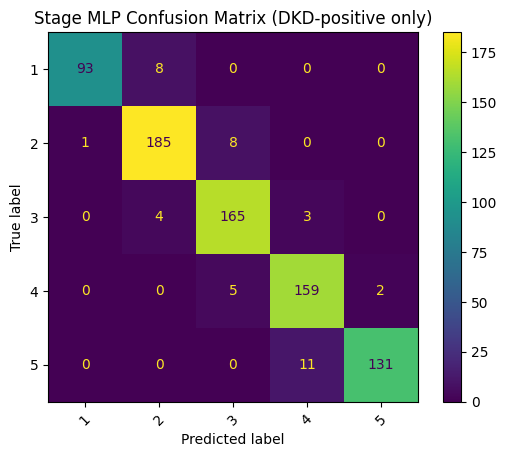

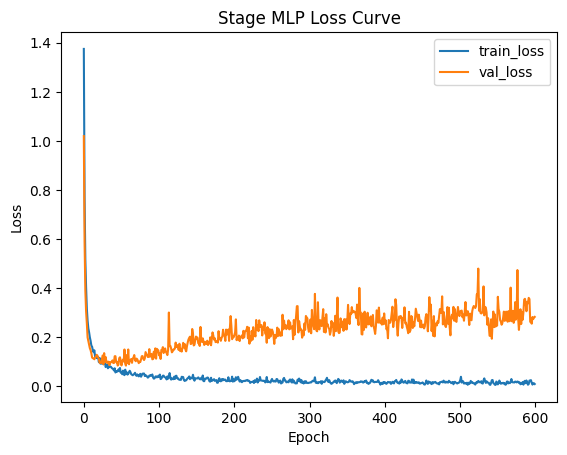

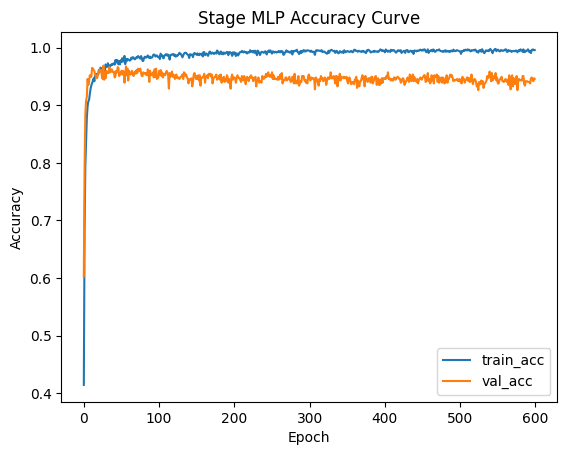

In [17]:

class MLP(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, hidden=(128, 64), dropout=0.2):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def train_torch_classifier(
    X_train_np, y_train_np,
    X_val_np, y_val_np,
    num_classes: int,
    epochs: int = 600,
    batch_size: int = 64,
    lr: float = 1e-3
):
    Xtr = torch.tensor(X_train_np, dtype=torch.float32)
    ytr = torch.tensor(y_train_np, dtype=torch.long)
    Xva = torch.tensor(X_val_np, dtype=torch.float32)
    yva = torch.tensor(y_val_np, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch_size, shuffle=True)

    model = MLP(in_dim=X_train_np.shape[1], out_dim=num_classes).to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    hist = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()

            total_loss += loss.item() * len(xb)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += len(xb)

        train_loss = total_loss / total
        train_acc = correct / total

        model.eval()
        with torch.no_grad():
            logits_va = model(Xva.to(DEVICE))
            val_loss = loss_fn(logits_va, yva.to(DEVICE)).item()
            val_pred = logits_va.argmax(dim=1).cpu().numpy()
            val_acc = accuracy_score(y_val_np, val_pred)

        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)
        hist["train_acc"].append(train_acc)
        hist["val_acc"].append(val_acc)

        if ep % 10 == 0 or ep == 1:
            print(f"Epoch {ep:03d} | train_loss={train_loss:.4f} train_acc={train_acc:.3f} | val_loss={val_loss:.4f} val_acc={val_acc:.3f}")

    return model, hist

# ---- Binary MLP ----
mlp_bin, hist_bin = train_torch_classifier(
    Xb_train_bal, yb_train_bal,
    Xb_test_proc, yb_test.to_numpy(),
    num_classes=2,
    epochs=600,
    batch_size=64,
    lr=1e-3
)

# Evaluation: binary
mlp_bin.eval()
with torch.no_grad():
    logits = mlp_bin(torch.tensor(Xb_test_proc, dtype=torch.float32).to(DEVICE))
    probs = torch.softmax(logits, dim=1).cpu().numpy()
    y_pred = probs.argmax(axis=1)
    y_prob_pos = probs[:, 1]

print("\nBinary MLP accuracy:", accuracy_score(yb_test, y_pred))
print(classification_report(yb_test, y_pred))

cm = confusion_matrix(yb_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Binary MLP Confusion Matrix")
plt.show()

# Curves: loss and accuracy
plt.figure()
plt.plot(hist_bin["train_loss"], label="train_loss")
plt.plot(hist_bin["val_loss"], label="val_loss")
plt.title("Binary MLP Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist_bin["train_acc"], label="train_acc")
plt.plot(hist_bin["val_acc"], label="val_acc")
plt.title("Binary MLP Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(yb_test, y_prob_pos)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"MLP AUC={roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("Binary ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# ---- Stage MLP ----
num_stage_classes = len(stage_classes)
mlp_stage, hist_stage = train_torch_classifier(
    Xs_train_bal, ys_train_bal,
    Xs_test_proc, y_test_stage_idx,
    num_classes=num_stage_classes,
    epochs=600,
    batch_size=64,
    lr=1e-3
)

# Evaluation: stage
mlp_stage.eval()
with torch.no_grad():
    logits_s = mlp_stage(torch.tensor(Xs_test_proc, dtype=torch.float32).to(DEVICE))
    probs_s = torch.softmax(logits_s, dim=1).cpu().numpy()
    y_pred_s_idx = probs_s.argmax(axis=1)

y_pred_stage = np.array([idx_to_stage[i] for i in y_pred_s_idx])
y_true_stage = ys_test_clean.to_numpy()

print("\nStage MLP accuracy:", accuracy_score(y_true_stage, y_pred_stage))
print(classification_report(y_true_stage, y_pred_stage))

cm_s = confusion_matrix(y_true_stage, y_pred_stage, labels=stage_classes)
ConfusionMatrixDisplay(cm_s, display_labels=stage_classes).plot(xticks_rotation=45)
plt.title("Stage MLP Confusion Matrix (DKD-positive only)")
plt.show()

plt.figure()
plt.plot(hist_stage["train_loss"], label="train_loss")
plt.plot(hist_stage["val_loss"], label="val_loss")
plt.title("Stage MLP Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist_stage["train_acc"], label="train_acc")
plt.plot(hist_stage["val_acc"], label="val_acc")
plt.title("Stage MLP Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## 5) End-to-end inference

Detect DKD, return risk probability, then stage if DKD is detected.

In [18]:

def predict_patient(patient_df_one_row: pd.DataFrame, dkd_threshold: float = 0.5):
    assert len(patient_df_one_row) == 1
    Xp = preprocess.transform(patient_df_one_row[FEATURE_COLS])

    # DKD probability
    mlp_bin.eval()
    with torch.no_grad():
        logits = mlp_bin(torch.tensor(Xp, dtype=torch.float32).to(DEVICE))
        prob_pos = torch.softmax(logits, dim=1).cpu().numpy()[0, 1]

    dkd_detected = prob_pos >= dkd_threshold
    result = {"dkd_detected": bool(dkd_detected), "dkd_risk_probability": float(prob_pos)}

    if dkd_detected:
        mlp_stage.eval()
        with torch.no_grad():
            logits_s = mlp_stage(torch.tensor(Xp, dtype=torch.float32).to(DEVICE))
            probs_s = torch.softmax(logits_s, dim=1).cpu().numpy()[0]
            pred_idx = int(np.argmax(probs_s))
        result["predicted_stage"] = int(idx_to_stage[pred_idx])
        result["stage_probabilities"] = {int(idx_to_stage[i]): float(probs_s[i]) for i in range(len(probs_s))}
    else:
        result["predicted_stage"] = None
        result["stage_probabilities"] = None

    return result

# Example: run on the first test patient
example_patient = X_test.iloc[[0]].copy()
print(predict_patient(example_patient))


{'dkd_detected': True, 'dkd_risk_probability': 1.0, 'predicted_stage': 1, 'stage_probabilities': {1: 1.0, 2: 2.2298256990849197e-12, 3: 2.2861256756825857e-30, 4: 0.0, 5: 0.0}}


## 6) Baselines: Random Forest and XGBoost

Binary: confusion matrix + ROC
Stage: confusion matrix (DKD-positive only)


Random Forest (Binary) accuracy: 0.98875
              precision    recall  f1-score   support

           0       0.94      0.68      0.79        25
           1       0.99      1.00      0.99       775

    accuracy                           0.99       800
   macro avg       0.97      0.84      0.89       800
weighted avg       0.99      0.99      0.99       800



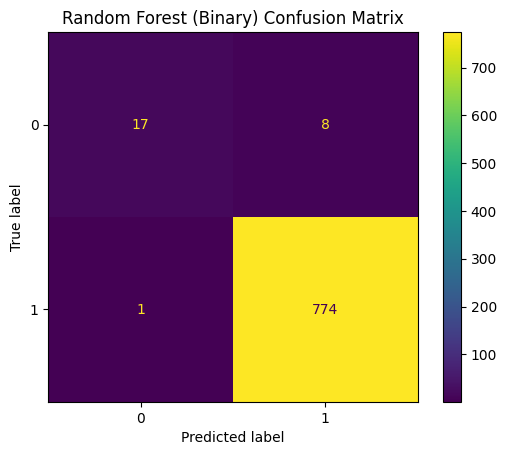

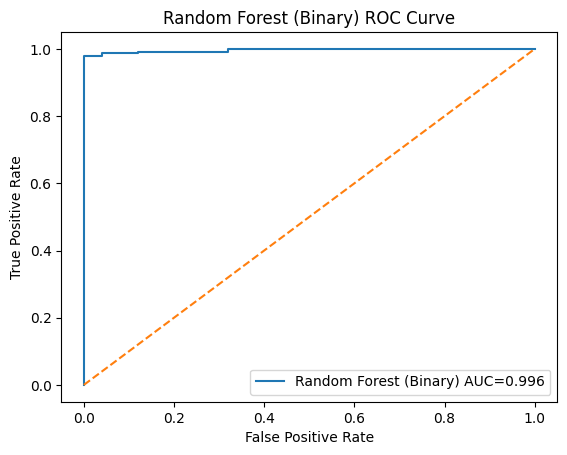


XGBoost (Binary) accuracy: 0.99
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        25
           1       1.00      0.99      0.99       775

    accuracy                           0.99       800
   macro avg       0.90      0.96      0.92       800
weighted avg       0.99      0.99      0.99       800



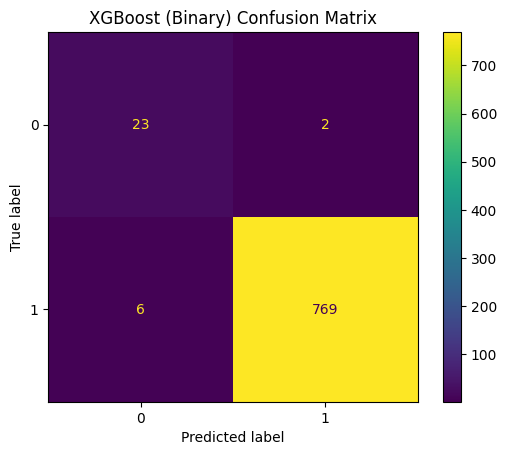

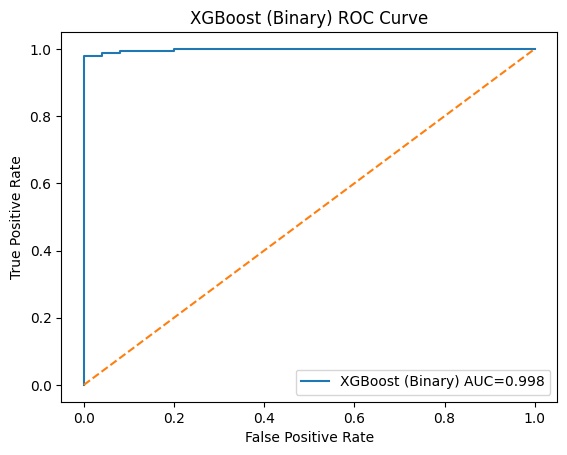


Random Forest (Stage) stage accuracy: 0.9948387096774194
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       101
           2       0.99      1.00      1.00       194
           3       1.00      0.99      0.99       172
           4       0.99      0.99      0.99       166
           5       0.99      1.00      1.00       142

    accuracy                           0.99       775
   macro avg       1.00      0.99      0.99       775
weighted avg       0.99      0.99      0.99       775



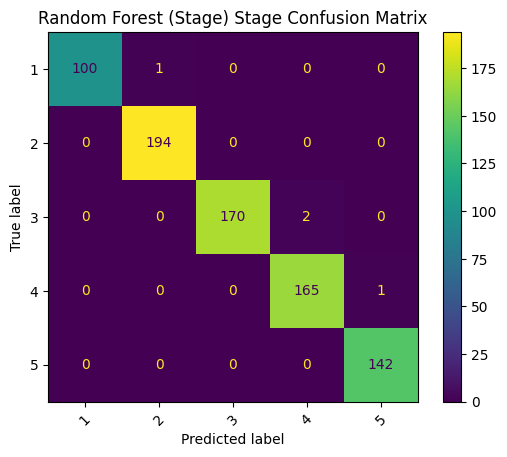


XGBoost (Stage) stage accuracy: 0.9935483870967742
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       101
           2       0.98      0.99      0.99       194
           3       0.99      0.99      0.99       172
           4       1.00      0.99      1.00       166
           5       0.99      1.00      1.00       142

    accuracy                           0.99       775
   macro avg       0.99      0.99      0.99       775
weighted avg       0.99      0.99      0.99       775



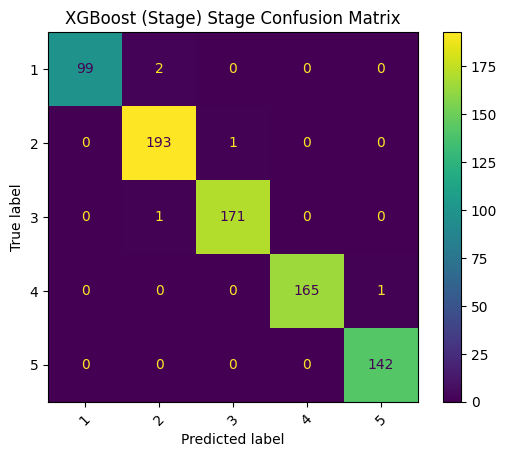

In [19]:

# -------------------------
# Binary baselines
# -------------------------
rf_bin = RandomForestClassifier(
    n_estimators=500,
    random_state=SEED,
    class_weight="balanced_subsample"
)
rf_bin.fit(Xb_train_bal, yb_train_bal)

xgb_bin = XGBClassifier(
    n_estimators=800,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=SEED,
    eval_metric="logloss"
)
xgb_bin.fit(Xb_train_bal, yb_train_bal)

def eval_binary_model(name, model, X_test_np, y_test_np):
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_np)[:, 1]
    else:
        y_prob = model.predict(X_test_np)
    y_pred = (y_prob >= 0.5).astype(int)

    print(f"\n{name} accuracy:", accuracy_score(y_test_np, y_pred))
    print(classification_report(y_test_np, y_pred))

    cm = confusion_matrix(y_test_np, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test_np, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} AUC={roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(f"{name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

eval_binary_model("Random Forest (Binary)", rf_bin, Xb_test_proc, yb_test.to_numpy())
eval_binary_model("XGBoost (Binary)", xgb_bin, Xb_test_proc, yb_test.to_numpy())

# -------------------------
# Stage baselines (DKD-positive only)
# -------------------------
rf_stage = RandomForestClassifier(
    n_estimators=600,
    random_state=SEED,
    class_weight="balanced_subsample"
)
rf_stage.fit(Xs_train_proc, y_train_stage_idx)

xgb_stage = XGBClassifier(
    n_estimators=900,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=SEED,
    eval_metric="mlogloss"
)
xgb_stage.fit(Xs_train_proc, y_train_stage_idx)

def eval_stage_model(name, model, X_test_np, y_test_idx):
    y_pred_idx = model.predict(X_test_np)
    y_pred_stage = np.array([idx_to_stage[int(i)] for i in y_pred_idx])
    y_true_stage = np.array([idx_to_stage[int(i)] for i in y_test_idx])

    print(f"\n{name} stage accuracy:", accuracy_score(y_true_stage, y_pred_stage))
    print(classification_report(y_true_stage, y_pred_stage))

    cm = confusion_matrix(y_true_stage, y_pred_stage, labels=stage_classes)
    ConfusionMatrixDisplay(cm, display_labels=stage_classes).plot(xticks_rotation=45)
    plt.title(f"{name} Stage Confusion Matrix")
    plt.show()

eval_stage_model("Random Forest (Stage)", rf_stage, Xs_test_proc, y_test_stage_idx)
eval_stage_model("XGBoost (Stage)", xgb_stage, Xs_test_proc, y_test_stage_idx)


## 7) SHAP explainability (global + patient-level)

Recommended:
- Use TreeExplainer on XGBoost for stable explanations.
- Global: summary plot
- Patient-level: waterfall plot for one patient

Note: With preprocessing, the model uses transformed feature space. We recover feature names from the pipeline for readability.

Transformed feature count: 34


C:\Users\DELL\AppData\Local\Temp\ipykernel_13868\520257308.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=True)


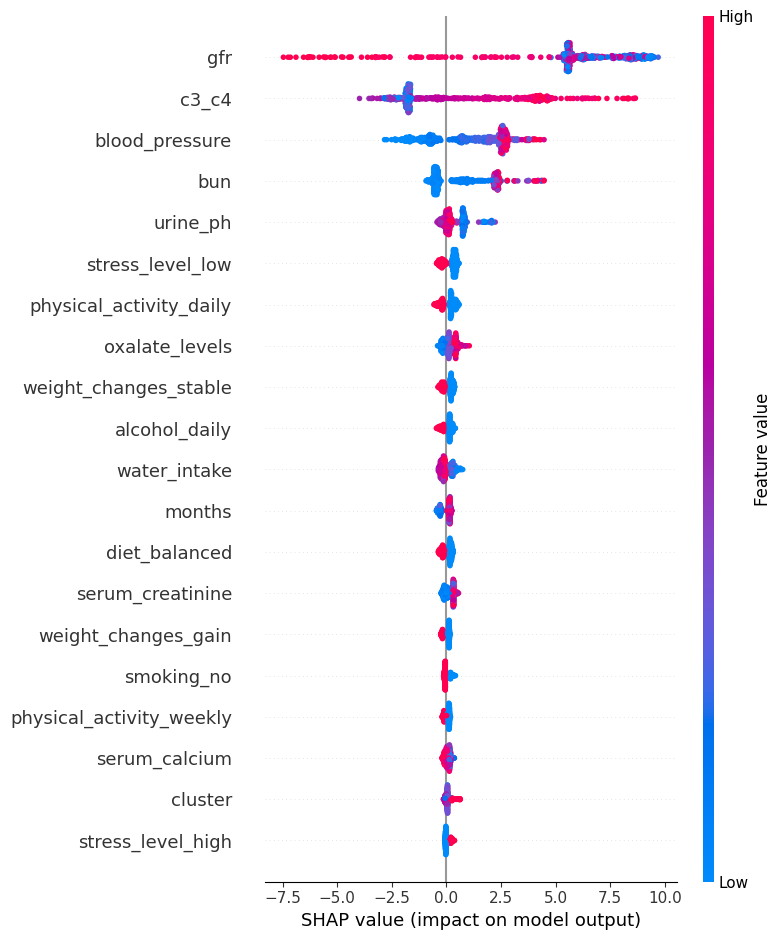

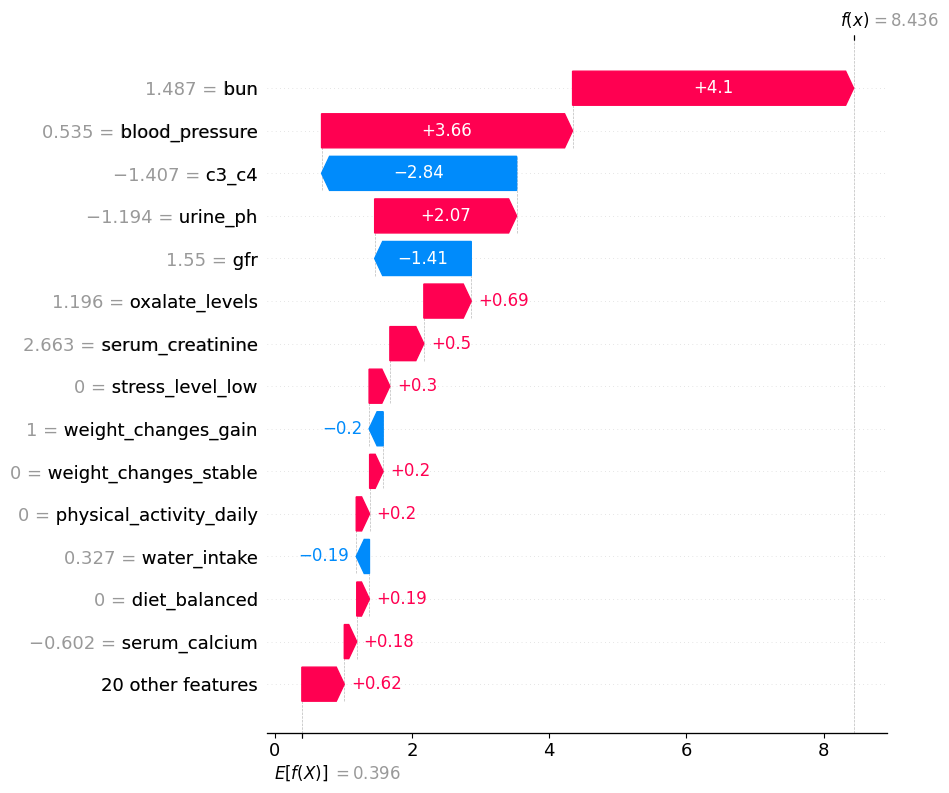

In [20]:

def get_feature_names_from_preprocess(preprocess: ColumnTransformer):
    names = []
    for name, trans, cols in preprocess.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "named_steps") and "onehot" in trans.named_steps:
            ohe = trans.named_steps["onehot"]
            ohe_names = list(ohe.get_feature_names_out(cols))
            names.extend(ohe_names)
        else:
            # numeric pipeline
            names.extend(list(cols))
    return names

feature_names = get_feature_names_from_preprocess(preprocess)
print("Transformed feature count:", len(feature_names))

# Global SHAP for XGBoost (binary)
X_shap = Xb_test_proc[: min(500, Xb_test_proc.shape[0])]
explainer = shap.TreeExplainer(xgb_bin)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=True)

# Patient-level SHAP: pick one patient
patient_idx = 0
x_patient = Xb_test_proc[patient_idx:patient_idx+1]
sv_patient = explainer.shap_values(x_patient)

# Waterfall plot (binary class 1)
base_value = explainer.expected_value
try:
    # Newer SHAP API
    exp = shap.Explanation(values=sv_patient[0], base_values=base_value, data=x_patient[0], feature_names=feature_names)
    shap.plots.waterfall(exp, max_display=15, show=True)
except Exception:
    # Fallback
    shap.waterfall_plot(shap.Explanation(values=sv_patient[0], base_values=base_value, data=x_patient[0], feature_names=feature_names), max_display=15)
